# Inference with the model on openEO

This notebook demonstrates how to use a trained model for inference with onnxruntime in an udf.

In [18]:
# Make the connection and authenticate
import openeo

#Choose preferred backend
conn = openeo.connect("https://openeo.cloud/").authenticate_oidc()


Authenticated using refresh token.


A workflow for processing Sentinel-2 Level-2A earth observation data using openEO in orden to obtain the desired data, compatible with the classifier


In [21]:
# Load Sentinel-2 Level-2A data cube
s2_cube = conn.load_collection(
                collection_id = "SENTINEL2_L2A",
                spatial_extent = {
                  "west": 16.341922243401232,
                  "east": 16.41408626641795,
                  "south": 47.96234024970855,
                  "north": 48.00780777335356
                },
                temporal_extent = ["2023-05-01","2023-09-30"],
                bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","SCL"],
                properties = {"eo:cloud_cover": lambda x: x.lte(65)}
)


# Create weekly composites by taking the mean
s2_cube = s2_cube.process("mask_scl_dilation", data=s2_cube, scl_band_name="SCL").filter_bands(s2_cube.metadata.band_names[:-1])

# Create weekly composites by taking the mean
s2_cube = s2_cube.aggregate_temporal_period(
    period = "week",
    reducer = "mean"
)

# Fill gaps in the data using linear interpolation
s2_cube = s2_cube.apply_dimension(
    dimension = "t",
    process = "array_interpolate_linear"
)

s2_cube_median = s2_cube.reduce_dimension(dimension="t",reducer="median")

Load in the model from the vito artifactory and the required dependencies and excecute the prediction job. The output is stored as a netCDF in the local directory

In [36]:

# Supply the model as a URL. The model is stored in artifactory
model_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/photovoltaic/rf_1_median_depth_15.onnx"
udf = openeo.UDF.from_file(
    "udf_rf_onnx.py", 
    context={
        "model_url": model_url
    }
)

# Add the onnx dependencies to the job options. You can reuse this existing dependencies archive
dependencies_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/onnx_dependencies_1.16.3.zip"
job_options = {
    "udf-dependency-archives": [
        f"{dependencies_url}#onnx_deps"
    ],
}


# Reduce the bands dimesnion to a single prediction using the udf
prediction = s2_cube_median.reduce_bands(reducer=udf)

# Post-process the data with an opening (erosion + dilation)
import numpy as np
eroded_cube = (prediction.apply_kernel(kernel=np.ones((3,3)),factor=1/9) >= 1) * 1.0
dilated_cube = (eroded_cube.apply_kernel(kernel=np.ones((3,3)),factor=1/9) > 0) * 1.0

prediction_job = dilated_cube.execute_batch(
    "./photovoltaic_prediction_median_summer_2023.tiff",
    job_options=job_options,
    title="photovoltaic_prediction_median_summer_2023"
)


0:00:00 Job 'vito-j-2404047545724f1fbee4077369efc126': send 'start'
0:00:23 Job 'vito-j-2404047545724f1fbee4077369efc126': queued (progress N/A)
0:00:30 Job 'vito-j-2404047545724f1fbee4077369efc126': queued (progress N/A)
0:00:37 Job 'vito-j-2404047545724f1fbee4077369efc126': queued (progress N/A)
0:00:45 Job 'vito-j-2404047545724f1fbee4077369efc126': queued (progress N/A)
0:00:56 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)
0:01:09 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)
0:01:25 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)
0:01:45 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)
0:02:10 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)
0:02:41 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)
0:03:19 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)
0:04:06 Job 'vito-j-2404047545724f1fbee4077369efc126': running (progress N/A)


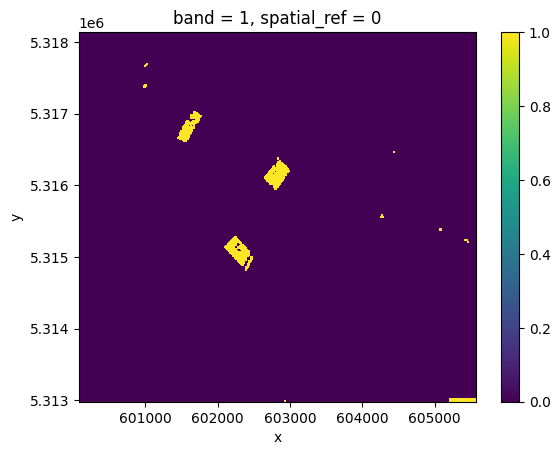

In [37]:
import rioxarray
rioxarray.open_rasterio("./photovoltaic_prediction_median_summer_2023.tiff")[0].plot.imshow()